In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob
from astropy import units as u
import random
import h5py
import itertools
import multiprocessing as mp
import time
import pickle

from astropy.timeseries import BoxLeastSquares, LombScargle
from scipy.signal import find_peaks, peak_widths
from sklearn.preprocessing import MinMaxScaler
from gatspy import datasets, periodic

import altair as alt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

In [38]:
%matplotlib inline

In [2]:
ff = h5py.File(f'{tb.cat_dir}/asassn_tess_inspected.hdf5', mode="r")

df = {}
for key in list(ff):
    if key == 'type':
        df[key] = np.array(ff[key].value, dtype='str')
    else:
        df[key] = ff[key].value
    
ff.close()
sample = pd.DataFrame(data=df)

/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
ls_period, bls_period = [], []
for ID in list(sample['tic_id']):
    infile = open(f'{tb.ps_dir}/{ID}_ps.pkl','rb')
    ps_dict = pickle.load(infile)
    infile.close()
    ls_period.append(ps_dict['ls_best_period'])
    bls_period.append(ps_dict['bls_best_period'])
sample['ls_period'] = np.array(ls_period)
sample['bls_period'] = np.array(bls_period)

In [88]:
sample['period'][2]

6.6801745

In [85]:
i = 2
ls_mult = [c*sample['ls_period'][i] for c in range(1,5)]
data = tb.readSourceFiles(sample['tic_id'][i])[0]

/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


In [89]:
len(flux)

49872

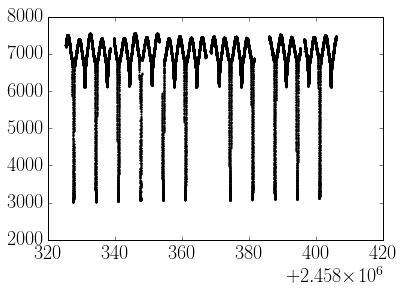

In [87]:
period = sample['period'][i]
tarr = data.time.jd
flux = data['pdcsap_flux']
flux_err = data['pdcsap_flux_err']
tarr = tarr[~np.isnan(flux)]
flux_err = flux_err[~np.isnan(flux)]
flux = flux[~np.isnan(flux)]

plt.scatter(tarr, flux, color='k', s=1)
plt.show()

In [61]:
model = periodic.SuperSmoother(fit_period=True)
model.optimizer.period_range = (2.7, 2.9)

In [62]:
t0 = time.time()
model.fit(tarr, flux, flux_err);
print(time.time() - t0)

Finding optimal frequency:
 - Estimated peak width = 1.51
 - Using 5 steps per peak; omega_step = 0.302
 - User-specified period range:  2.5 to 2.9
 - Computing periods at 2 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
42.649258613586426


In [63]:
model.best_period

2.794887555939941

In [75]:
ex_per

array([2.])

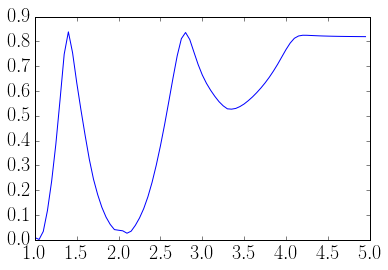

In [81]:
ex_per = np.arange(1,5,.05)
scores = model.score(ex_per)

plt.plot(ex_per, scores)
plt.show()

[Text(0, 0.5, 'r magnitude'), Text(0.5, 0, 'phase')]

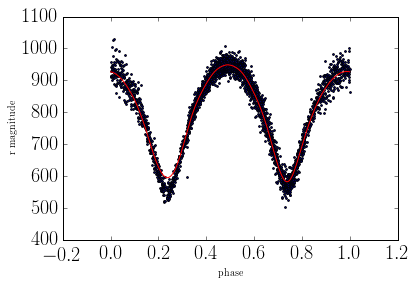

In [66]:
period = model.best_period
tfit = np.linspace(0, period, 1000)
magfit = model.predict(tfit)

# Plot the results
phase = (tarr / period) % 1
phasefit = (tfit / period)

fig, ax = plt.subplots()
ax.scatter(phase, np.array(flux), s=3)
ax.plot(phasefit, magfit, '-', color='r')
ax.set(xlabel='phase', ylabel='r magnitude')
# ax.invert_yaxis()